In [6]:
# imports
import numpy as np
import random
import math
import timeit
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from collections import Counter

In [7]:
# Read data functions
def string_to_spin(string):
    """
    Convert string of 0 and 1 to a np array of spins (-1, 1):
    0 -> -1
    1 -> +1
    :param string: String: original string.
    :return: np.array: Spins.
    """
    return (np.array(list(map(int, list(string)))) * 2 - 1)

def read_configurations(name, n):
    """
    Reads a file and returns a np array with the spin configuration.
    :param name: String: Name of the file.
    :param n: Int: Number of spins.
    :return: np.array: Matrix of shape (Data_number, num_spins).
    """
    spins = np.array([])
    filepath = name
    with open(filepath, 'r') as fp:
        s = fp.readlines()  
    spins = np.array([string_to_spin(e.rstrip()) for e in s]).flatten()
    return np.reshape(spins, (int(len(spins)/n), n)).astype('int')

def read_j_coef(name, n):
    """
    Reads a file and returns a np array with the j coefficients.
    :param name: String: Name of the file.
    :param n: Int: Number of spins.
    :return: np.array: Array of shape 2*n.
    """
    j = np.zeros((n, 2))
    filepath = name
    with open(filepath) as fp:
        for line in tqdm_notebook(fp.readlines()):
            list_line = line.split()
            if len(list_line) == 2:
                el = list_line[-1]
                list_line[-1] = el[0]
                list_line.append(el[1:])
            s = int(list_line[0])-1
            d = int(list_line[1])-1
            # list line té 3 llocs: numspin, (1 o 2) i el valor de J
            j[s, d] = list_line[-1]
    return j

In [8]:
# get neighbours
def get_spin_neighbours(i, l):
    """
    From a spin i in a lxl grid, gives the neighbours of this spin.
    :param i: Int: Position of the spin.
    :param l: Int: Length of the square grid.
    :return: np.array: Array containing the index of the neighbour spins.
    """
    column = int(i % l)
    row = int(i / l)
    right = int(row * l + (column + 1)%l)
    up = int(((row + 1)%l) * l + column)
    left = int(row * l + (column - 1)%l)
    down = int(((row - 1)%l) * l + column)
    return np.array([right, up, left, down])

def f_nbrs(n):
    l = int(np.sqrt(n))
    return np.array([get_spin_neighbours(i, l) for i in range(n)])

In [9]:
def hamiltonian(spins, h, j):
    hamiltonian = 0
    n, d = j.shape
    l = int(np.sqrt(n))
    for i in range(n):
        subsum = 0
        for k in range(d):
            subsum += spins[get_spin_neighbours(i, l)[k]] * j[i, k]
        hamiltonian += spins[i] * subsum
    hamiltonian += np.dot(h, spins)
    return -hamiltonian

In [83]:
n = 16

j = read_j_coef('L4/sample3/bonds.dat', n)
h = np.zeros(n)
spins = read_configurations('L4/sample3/configurations_T1.dat', n)
spins = spins[::4]# en el cas de n=16
#print(j)
print(spins[:5])
hams = np.array([round(hamiltonian(s, h, j), 8) for s in spins])
for i in range(0, 10):
    print(hams[i])
print(spins.shape)
sample = spins[np.random.choice(spins.shape[0], size=25000, replace=False), :]
print(sample.shape)



[[ 1  1  1  1  1 -1 -1  1  1 -1  1 -1  1  1 -1 -1]
 [ 1  1  1  1  1 -1 -1 -1 -1  1 -1  1 -1 -1  1  1]
 [-1 -1 -1 -1  1  1  1  1 -1 -1 -1 -1  1  1 -1 -1]
 [ 1  1  1  1  1 -1 -1  1 -1  1 -1 -1 -1 -1  1  1]
 [-1 -1 -1 -1  1  1  1  1  1 -1  1 -1  1  1 -1 -1]]
-10.1000005
-11.7000003
-6.4066669
-10.2866671
-10.8466671
-7.9933339
-11.7000003
-10.1200003
-11.7000003
-11.7000003
(25000, 16)
(25000, 16)


1.0000000000000044



1.999
17729.80804343228


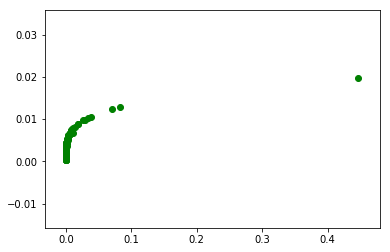

In [84]:
counts = Counter(hams)
dict(counts)
prob = {}
for k, v in dict(counts).items():
    prob[k] = float(v)/25000
print(sum(prob.values()))
from sklearn.linear_model import LinearRegression
r = float('inf')
dif = 0.
for t in tqdm_notebook(np.arange(1.999, 5, 0.01)):
    sum_denom = 0
    for k, v in prob.items():
        sum_denom += np.exp(-k/t)
    probab = {}
    for k, v in prob.items():
        probab[k] = np.exp(-k/t)/sum_denom
    
    fit_x = np.array(list(prob.values())).astype(float)
    fit_y = np.array(list(probab.values())).astype(float)
    r_sq = np.sum(abs(fit_x - fit_y))
    if r_sq < r:
        r = r_sq
        dif = t
print(dif)

sum_denom = 0
for k, v in prob.items():
    sum_denom += np.exp(-k/dif)
print(sum_denom)
probab = {}
for k, v in prob.items():
    probab[k] = np.exp(-k/dif)/sum_denom

    

plt.scatter(prob.values(), probab.values(), c='green')
plt.show()


In [ ]:
values, base = np.histogram(hams, bins=1000000)
cumulative = np.cumsum(values, dtype='float')
x_data = base[:-1]
y_data = cumulative/25000
y_reg = np.log(1-y_data)
plt.plot(x_data, values, c='green')
plt.show()
plt.plot(x_data, y_data, c='green')
plt.show()
plt.plot(x_data, y_reg, c='green')
plt.show()

In [70]:
a = np.array([0,0,1,0,1,1,0,1,1,0,1,0,1,0,1,1], dtype='int')
b = np.array([1,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0], dtype='int')
def inverse(a):
    return np.abs(a-1)
def changes(a, b):
    return min(np.sum(np.abs(a-b)), np.sum(np.abs(a-inverse(b))))
print(a)
print(inverse(a))
print(changes(a, b))

[0 0 1 0 1 1 0 1 1 0 1 0 1 0 1 1]
[1 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0]
0


In [71]:
max_freq = np.flip(np.array([0,0,1,1,0,1,0,1,1,1,1,0,0,0,0,0], dtype='int'))
print(max_freq)

[0 0 0 0 0 1 1 1 1 0 1 0 1 1 0 0]


In [77]:
import operator as op
from functools import reduce

def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer / denom

In [78]:
print(ncr(16,2))

120.0


[(13792.0, 11180), (13808.0, 2068), (18975.0, 1759), (14944.0, 975), (14688.0, 836)]
{0.0: 11180.0, 1.0: 327.5625, 3.0: 3.1732142857142858, 5.0: 0.3347069597069597, 2.0: 21.25, 4.0: 0.6, 7.0: 0.08881118881118881, 8.0: 0.014296814296814297, 6.0: 0.062187812187812185}
[(0.0, 11180), (1.0, 5241), (2.0, 2550), (3.0, 1777), (5.0, 1462), (4.0, 1092), (7.0, 1016), (6.0, 498), (8.0, 184)]


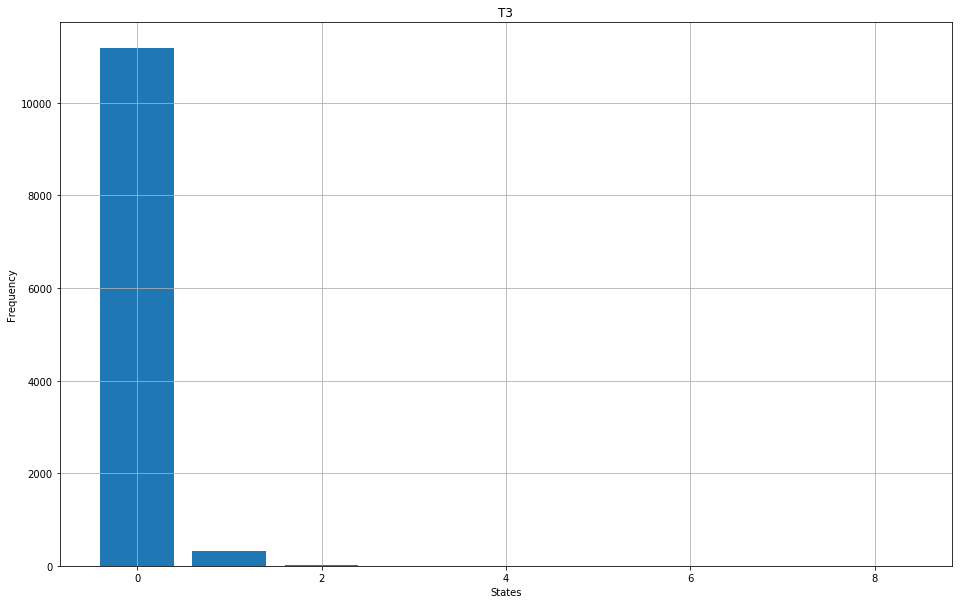

In [85]:

hist_s = (sample+1)/2
new = []
new1 = []
for i in hist_s:
    sub = 0
    sub2 = 0
    for k in range(len(i)):
        sub += i[k] * 2**k
        sub2 += (1-i[k]) * 2**k
    new1.append(min(sub, sub2))
    new.append(changes(max_freq, i))
print(Counter(new1).most_common(5))
counts = dict(Counter(new))

for k, v in counts.items():
    counts[k] = counts[k]/ncr(16, int(k))
print(counts)
print(Counter(new).most_common(9))

plt.figure(figsize = (16, 10))
ax = plt.axes()
plt.title('T3')
plt.xlabel('States')
plt.ylabel('Frequency')
plt.bar(counts.keys(), counts.values())
#plt.xlim(0, 34000)
#plt.ylim(0, 9000)
#plt.xticks(np.arange(-0.07, 0.071, 0.01))
plt.grid()
#plt.savefig('t3.png')
plt.show()